# ENCODER-DECODER RECURRENT NEURAL NETWORK

In this project I am going to design and develop Encoder-Decoder RNN  with Pytorch and CUDA. The goal is to create an English to French translator.

To carry out this project I implemented the knowledge I gained in the Udacity Natural Language Processing Nanodegree.

In [2]:
import os
import random
import torch
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

## 1. DATA
This type of project is computationally expensive, for this reason I will use a Dataset created by Udacity that uses a short vocabulary. This way I will test the architecture with a much lower computational and time cost.

### 1.1 Load Data
The data is located in `data/small_vocab_en` and `data/small_vocab_fr`. The `small_vocab_en` file contains English sentences with their French translations in the `small_vocab_fr` file. Load the English and French data from these files from running the cell below.

In [3]:
def load_data(path):
    input_file = os.path.join(path)
    with open(input_file, "r", encoding='utf-8') as f:
        data = f.read()

    return data.split('\n')

In [4]:
# Load English data
english_sentences = load_data('data/small_vocab_en')
# Load French data
french_sentences = load_data('data/small_vocab_fr')

print('DATA SET LOADED')

DATA SET LOADED


Show some examples:

In [5]:
print('Phrase in English: ', english_sentences[20])
print('Phrase in French: ', french_sentences[20])

Phrase in English:  china is usually pleasant during november , and it is never quiet in october .
Phrase in French:  chine est généralement agréable en novembre , et il est jamais tranquille en octobre .


### 1.2 Create and apply a word counter
The following function creates a dictionary with the word count, and return the number of words that have the longest phrase.

In [6]:
def world_count(texts):
    w_count = {}
    max_w = 0
    
    for i in texts:
        ws = i.split()
        
        for w in  ws:
            if w not in w_count:
                w_count[w] = 1
            else:
                w_count[w] += 1
                
        if len(ws)>max_w:
            max_w = len(ws)
            
    return w_count, max_w

In [7]:
en_w_count, en_max_w = world_count(english_sentences)
print('Max number of words in a english phrase: ', en_max_w)
print('English vocablary size: ', len(en_w_count))

fr_w_count, fr_max_w = world_count(french_sentences)
print('Max number of words in a french phrase: ', fr_max_w)
print('French vocablary size: ', len(fr_w_count))

Max number of words in a english phrase:  17
English vocablary size:  227
Max number of words in a french phrase:  23
French vocablary size:  355


Looking at the word counter we can see that the dataset we are using was carefully created, it does not have a large number of words and all of them are repeated an acceptable number of times.

In [8]:
print('======================  English word counter  ====================','\n','\n',en_w_count)

======================  English word counter  ==================== 
 
 {'new': 12197, 'jersey': 11225, 'is': 205858, 'sometimes': 37746, 'quiet': 8693, 'during': 74933, 'autumn': 9004, ',': 140897, 'and': 59850, 'it': 75137, 'snowy': 8898, 'in': 75525, 'april': 8954, '.': 129039, 'the': 67628, 'united': 11270, 'states': 11270, 'usually': 37507, 'chilly': 8770, 'july': 8956, 'freezing': 8928, 'november': 8951, 'california': 11250, 'march': 9023, 'hot': 8639, 'june': 9133, 'mild': 8743, 'cold': 8878, 'september': 8958, 'your': 9734, 'least': 27564, 'liked': 13546, 'fruit': 27105, 'grape': 4703, 'but': 63987, 'my': 9700, 'apple': 4652, 'his': 9700, 'favorite': 27371, 'orange': 4651, 'paris': 11334, 'relaxing': 8696, 'december': 8945, 'busy': 8791, 'spring': 9102, 'never': 37500, 'our': 8932, 'lemon': 4652, 'january': 9090, 'warm': 8890, 'lime': 4680, 'her': 9700, 'banana': 4652, 'he': 10786, 'saw': 648, 'a': 1944, 'old': 972, 'yellow': 972, 'truck': 1944, 'india': 11277, 'rainy': 8761, 't

In [9]:
print('======================  French word counter  ====================','\n','\n',fr_w_count)

======================  French word counter  ==================== 
 
 {'new': 11047, 'jersey': 11052, 'est': 196809, 'parfois': 37746, 'calme': 7256, 'pendant': 10741, "l'": 32917, 'automne': 14727, ',': 123135, 'et': 59851, 'il': 84079, 'neigeux': 1867, 'en': 105768, 'avril': 8954, '.': 135619, 'les': 65255, 'états-unis': 11210, 'généralement': 31292, 'froid': 16794, 'juillet': 8956, 'gèle': 3622, 'habituellement': 6215, 'novembre': 8951, 'california': 3061, 'mars': 9023, 'chaud': 16405, 'juin': 9133, 'légère': 63, 'fait': 2916, 'septembre': 8958, 'votre': 9368, 'moins': 27557, 'aimé': 24842, 'fruit': 23626, 'le': 35306, 'raisin': 4852, 'mais': 63987, 'mon': 9403, 'la': 49861, 'pomme': 4848, 'son': 16496, 'préféré': 22886, "l'orange": 4848, 'paris': 11334, 'relaxant': 8458, 'décembre': 8945, 'occupé': 7782, 'au': 25738, 'printemps': 9100, 'jamais': 37215, 'chaude': 1124, 'notre': 8319, 'citron': 4848, 'janvier': 9090, 'chaux': 4848, 'des': 2435, 'fruits': 3566, 'banane': 4848, 'aimé.'

### 1.3 Create and apply a word counter

Using the word counter I create a function that returns two Dictionary objects.  These dictionaries contain all the words that exceed a minimum number of repetitions in the dataset, and their assigned ID. One of the dictionaries has as key the word and as value the ID, and the other dictionary inverts the key and the value of the first one.

In [10]:
def create_dic(t_count, min_t=1, start=False, end=False, nan=False):
    id2t = {}
    t2id = {}
    id = 0
    
    if nan == True:                 # There is no word
        id2t[str(id)] = '<nan>'
        t2id['<nan>'] = id
        id += 1
    
    if start == True:               # start value of the phrase
        id2t[str(id)] = '<start>'
        t2id['<start>'] = id
        id += 1
        
    if end == True:                 # end value of the phrase
        id2t[str(id)] = '<end>'
        t2id['<end>'] = id
        id += 1
        
    for i in t_count:               
        if t_count[i] >= min_t:    # The word is repeated more than the minimum chosen
            
            t2id[i] = id
            id2t[str(id)] = i
            
            id += 1
            
    # add to the dictionary a token and an Id to the tokens that are not in the dictionary
    t2id['<str>'] = id            
    id2t[str(id)] = '<str>'

    return id2t, t2id

In [11]:
en_id2t, en_t2id = create_dic(en_w_count, min_t=1, start=True, end=True, nan=True)
fr_id2t, fr_t2id = create_dic(fr_w_count, min_t=1, start=True, end=True, nan=True)

**English dictionary whose key is the word and the value is the ID**

In [12]:
print(en_t2id)

{'<nan>': 0, '<start>': 1, '<end>': 2, 'new': 3, 'jersey': 4, 'is': 5, 'sometimes': 6, 'quiet': 7, 'during': 8, 'autumn': 9, ',': 10, 'and': 11, 'it': 12, 'snowy': 13, 'in': 14, 'april': 15, '.': 16, 'the': 17, 'united': 18, 'states': 19, 'usually': 20, 'chilly': 21, 'july': 22, 'freezing': 23, 'november': 24, 'california': 25, 'march': 26, 'hot': 27, 'june': 28, 'mild': 29, 'cold': 30, 'september': 31, 'your': 32, 'least': 33, 'liked': 34, 'fruit': 35, 'grape': 36, 'but': 37, 'my': 38, 'apple': 39, 'his': 40, 'favorite': 41, 'orange': 42, 'paris': 43, 'relaxing': 44, 'december': 45, 'busy': 46, 'spring': 47, 'never': 48, 'our': 49, 'lemon': 50, 'january': 51, 'warm': 52, 'lime': 53, 'her': 54, 'banana': 55, 'he': 56, 'saw': 57, 'a': 58, 'old': 59, 'yellow': 60, 'truck': 61, 'india': 62, 'rainy': 63, 'that': 64, 'cat': 65, 'was': 66, 'most': 67, 'loved': 68, 'animal': 69, 'dislikes': 70, 'grapefruit': 71, 'limes': 72, 'lemons': 73, 'february': 74, 'china': 75, 'pleasant': 76, 'october'

In [13]:
print(en_id2t)

{'0': '<nan>', '1': '<start>', '2': '<end>', '3': 'new', '4': 'jersey', '5': 'is', '6': 'sometimes', '7': 'quiet', '8': 'during', '9': 'autumn', '10': ',', '11': 'and', '12': 'it', '13': 'snowy', '14': 'in', '15': 'april', '16': '.', '17': 'the', '18': 'united', '19': 'states', '20': 'usually', '21': 'chilly', '22': 'july', '23': 'freezing', '24': 'november', '25': 'california', '26': 'march', '27': 'hot', '28': 'june', '29': 'mild', '30': 'cold', '31': 'september', '32': 'your', '33': 'least', '34': 'liked', '35': 'fruit', '36': 'grape', '37': 'but', '38': 'my', '39': 'apple', '40': 'his', '41': 'favorite', '42': 'orange', '43': 'paris', '44': 'relaxing', '45': 'december', '46': 'busy', '47': 'spring', '48': 'never', '49': 'our', '50': 'lemon', '51': 'january', '52': 'warm', '53': 'lime', '54': 'her', '55': 'banana', '56': 'he', '57': 'saw', '58': 'a', '59': 'old', '60': 'yellow', '61': 'truck', '62': 'india', '63': 'rainy', '64': 'that', '65': 'cat', '66': 'was', '67': 'most', '68': 

### 1.4 Data preprocessing

The first step in preprocessing the data is to transform the sentences into lists, where the list values are the words, creating a list of lists. The second step is to change the words with the respective IDs.

The following function does these two steps:

In [14]:
def tokenize(list, dict):
    list = [dict[i] for i in list]
    return list

In [15]:
def tokenize_list(list, dict):
    list = tokenize(list, dict)
    size = len(dict)
    out = []
    
    for i in list:
        arr = [0.]*size
        arr[i] = 1.
        out.append(arr)
    
    return out

### 1.5 Create Training, Validation and Test Datasets
The next step separates the phrases we have in the three datasets in a random way according to the proportion we choose

In [16]:
tr_db = []
te_db = []
va_db = []

tr_va_p = 0.7 
tr_p = 0.7

if fr_max_w > en_max_w:
    ph_lon = fr_max_w + 2
else:
    ph_lon = en_max_w + 2
    
for (en,fr) in zip(english_sentences, french_sentences):
    
    en = [en_t2id['<start>']] + tokenize(en.split(), en_t2id) + [en_t2id['<end>']]   # creta a list with the words id values 
    en = en + [0]*(ph_lon-len(en))
    fr = [fr_t2id['<start>']] + tokenize(fr.split(), fr_t2id) + [fr_t2id['<end>']]
    fr = fr + [0]*(ph_lon-len(fr))
    
    if random.random() < tr_va_p:
        if random.random() < tr_p:
            tr_db.append((torch.LongTensor(en), torch.LongTensor(fr)))
        else:
            va_db.append((torch.LongTensor(en), torch.LongTensor(fr)))
    else:
        te_db.append((torch.LongTensor(en), torch.LongTensor(fr)))
#     if random.random() < tr_va_p:
#         if random.random() < tr_p:
#             tr_db.append((en, fr))
#         else:
#             va_db.append((en, fr))
#     else:
#         te_db.append((en, fr))

In [17]:
print('Some examples:')
for i in range(4):
    print(te_db[i][0])

Some examples:
tensor([ 1, 25,  5, 20,  7,  8, 26, 10, 11, 12,  5, 20, 27, 14, 28, 16,  2,  0,
         0,  0,  0,  0,  0,  0,  0])
tensor([ 1, 43,  5, 44,  8, 45, 10, 37, 12,  5, 20, 21, 14, 22, 16,  2,  0,  0,
         0,  0,  0,  0,  0,  0,  0])
tensor([ 1,  3,  4,  5, 46,  8, 47, 10, 11, 12,  5, 48, 27, 14, 26, 16,  2,  0,
         0,  0,  0,  0,  0,  0,  0])
tensor([ 1, 49, 33, 34, 35,  5, 17, 50, 10, 37, 38, 33, 34,  5, 17, 36, 16,  2,
         0,  0,  0,  0,  0,  0,  0])


In [18]:
print('Some examples:')
for i in range(4):
    print(te_db[i][1])

Some examples:
tensor([ 1, 26,  5, 20,  7, 15, 27, 11, 12, 13,  5, 20, 28, 15, 29, 17,  2,  0,
         0,  0,  0,  0,  0,  0,  0])
tensor([ 1, 46,  5, 47, 15, 48, 11, 39, 13,  5, 20, 21, 15, 22, 17,  2,  0,  0,
         0,  0,  0,  0,  0,  0,  0])
tensor([ 1,  3,  4,  5, 49, 50, 51, 11, 12, 13,  5, 52, 53, 15, 27, 17,  2,  0,
         0,  0,  0,  0,  0,  0,  0])
tensor([ 1, 54, 36,  5, 34, 35, 37, 55, 11, 39, 40, 34, 35,  5, 37, 38, 17,  2,
         0,  0,  0,  0,  0,  0,  0])


1 mean that the phrase is starting (*start*), and 2 mean that it is the end of the phrase (*end*)

## 2. THE RNN

This model is created using two LSTM models, the Encoder and the Decoder. The layers we use in the model are:
* Embeding Layers (nn.Embedding()): A simple lookup table that stores embeddings of a fixed dictionary and size.
* Long Sort Term Memory Layer (LSTM())
* Full Conect Layers (Dense())
* Drop Out Layer



### 2.1 The Architecture

#### 2.1.1 Encoder
The encoder is the part of the neural network that "reads" the text and returns a matrix with the encoded information, to perform this step I am using a Bidirectional LSTM. The output matrix with the encoded information is obtained after inserting in a Dense NN the outputs of the first and last words. 
<img src='images/encoder_bd.png' width=50% height=50%/>

#### 2.1.2 Decoder
The decoder NN recive the characteristics of the text to translate, encoded in a array and using tha sequence to sequence architecture. The encoder output is the first input.
<img src='images/decoder.png' width=50% height=50%/>


In [19]:
import torch
from torch import nn
import torch.nn.functional as F

class Encoder_Decoder(nn.Module):

    def __init__(self, en_dic = len(en_t2id), fr_dic=len(fr_t2id), device='cuda'): #, decod_trainer):
        super(Encoder_Decoder, self).__init__()
        
        self.device = device
#         self.decod_trainer = decod_trainer
        
        # Embeding Layer
        # https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
        self.emb1 = nn.Embedding(en_dic+1, 200)
        self.emb2 = nn.Embedding(fr_dic+1, 250) 
        
        # Bidirectional LSTM Layer
        # https://pytorch.org/docs/1.9.1/generated/torch.nn.LSTM.html
        self.LSTM1 = nn.LSTM(200, 200, num_layers=1, dropout=0.0, batch_first=True, bidirectional=True)
        self.LSTM2 = nn.LSTM(250, 250, num_layers=2, dropout=0.0, batch_first=True)
        
        # Dense Layer
        self.Dense1 = nn.Linear(200*4, 250)
        self.Dense2 = nn.Linear(250, fr_dic*5)
        self.Dense3 = nn.Linear(fr_dic*5, fr_dic)
        
        #Activation Function
        self.ELU1 = nn.ELU()
        self.ELU2 = nn.ELU()
        self.ELU3 = nn.ELU()
        self.relu1 = nn.ReLU()
        
        #Drop Out layer
        self.dropout1 = nn.Dropout(p=0.3)
        
        
    def forward(self, x, y):
        
        output = []
        for ph, ph_dec in zip(x, y):
            
            #### ENCODER
            self.hidden1 = ( torch.zeros(2,1, 200).to(self.device), 
                       torch.zeros(2,1, 200).to(self.device) )
            
            
            for i in range(ph.size()[0]):
                if ph[i] == 0:
                    ph = ph[:i]
                    break
            out = ph.view((1,ph.size()[0]))
            out = self.emb1(out)
            out, self.hidden1 = self.LSTM1(out, self.hidden1)
            #out = self.ELU1(out)
            out = torch.cat((out[0][0],out[0][-1]), 0)
            out = self.Dense1(out)
            out = self.ELU2(out)
            out = self.dropout1(out)
            
            #### Decoder
            self.hidden2 = ( torch.zeros(2,1, 250).to(self.device), 
                       torch.zeros(2,1, 250).to(self.device) )
            
            for i in range(ph_dec.size()[0]):
                if ph_dec[i] == 2:
                    ph_dec = ph_dec[1:i]
                    break
            out = out.view((1,1,out.size()[0]))
            #out, self.hidden2 = self.LSTM2(out, self.hidden2)
            dec_inp = ph_dec.view((1,ph_dec.size()[0]))
            dec_inp = self.emb2(dec_inp)
            out = torch.cat((out, dec_inp), 1)
            out, self.hidden2 = self.LSTM2(out, self.hidden2)
            #out = self.ELU3(out)
            out = self.Dense2(out)
            out = self.relu1(out)
            out = self.dropout1(out)
            out = self.Dense3(out)
            
            
            output.append(out)
        return output
    
    def predict(self, x):
        end = False
        ph_tr = []
        output = []
        it = 0
        for ph in x:
            
            #### ENCODER
            self.hidden1 = ( torch.zeros(2,1, 200).to(self.device), 
                       torch.zeros(2,1, 200).to(self.device) )
            
            
            for i in range(ph.size()[0]):
                if ph[i] == 2:
                    ph = ph[:i+1]
                    break
            out = ph.view((1,ph.size()[0]))
            out = self.emb1(out)
            out, self.hidden1 = self.LSTM1(out, self.hidden1)
            #out = self.ELU1(out)
            out = torch.cat((out[0][0],out[0][-1]), 0)
            out = self.Dense1(out)
            out = self.ELU2(out)
            
            #### Decoder
            self.hidden2 = ( torch.zeros(2,1, 250).to(self.device), 
                       torch.zeros(2,1, 250).to(self.device) )
            
            out = out.view((1,1,out.size()[0]))
            
            while end == False and it<=25:
                if it != 0:
                    out = self.emb2(out)
                out, self.hidden2 = self.LSTM2(out, self.hidden2)
                out = self.Dense2(out)
                out = self.relu1(out)
                out = self.Dense3(out)
                out = out.max(2)[1]
                ph_tr.append(out.item())
                
                if out == 2:
                    end = True
                it += 1
            output.append(ph)
            ph = []
        return output
  
            
print(Encoder_Decoder())        

Encoder_Decoder(
  (emb1): Embedding(232, 200)
  (emb2): Embedding(360, 250)
  (LSTM1): LSTM(200, 200, batch_first=True, bidirectional=True)
  (LSTM2): LSTM(250, 250, num_layers=2, batch_first=True)
  (Dense1): Linear(in_features=800, out_features=250, bias=True)
  (Dense2): Linear(in_features=250, out_features=1795, bias=True)
  (Dense3): Linear(in_features=1795, out_features=359, bias=True)
  (ELU1): ELU(alpha=1.0)
  (ELU2): ELU(alpha=1.0)
  (ELU3): ELU(alpha=1.0)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
)


## 3. Training and Test

#### 3.1 Hyperparameters

In [20]:
batch_size = 5
epochs = 15
device = 'cuda'
#device = 'cpu'
display_step = 100
rnn = Encoder_Decoder(device=device).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(rnn.parameters(), lr=0.0001, betas=(0.85, 0.999))

tr_ds = DataLoader(tr_db, batch_size=batch_size, shuffle=True)
te_ds = DataLoader(te_db, batch_size=50, shuffle=True)
va_ds = DataLoader(va_db, batch_size=50, shuffle=False)

#### 3.2 Loss Function
In this case all sentences are not the same size, and it is not possible to introduce a tensor with arrays at different sizes in the loss function and ac. For this reason I need to customize both.

In [21]:
def loss_function(prediction, expected, optimizer, dict_len):
    loss = False
    counter = 0 
    for pred, exp in zip(prediction, expected):
        
        for i in range(exp.size()[0]):
            if exp[i] == 2:
                exp = exp[1:i+1]
                counter += i-1
                break
                
        if loss != False:
            loss += criterion( pred.view(-1,dict_len), exp.view(-1))*(i-1)
        else:
            loss = criterion( pred.view(-1,dict_len), exp.view(-1))*(i-1)
            
#         if exp.size() != pred.size():
#             print('ERROR: Dimensioality error between the prediction and the expected data')
        
    loss = loss/counter
    return loss

In [22]:
def acc_function(prediction, expected):
    
    acc = 0
    counter = 0 
    for pred, exp in zip(prediction, expected):
        pred = pred.detach().to('cpu')
        exp = exp.detach().to('cpu')
        
        for i in range(exp.size()[0]):
            if exp[i] == 2:
                exp = exp[1:i+1]
                counter += i-1
                break
                
#         print(pred[0].max(1)[1].size())
#         print(exp.size())
        pred = pred[0].max(1)[1].numpy()
        exp = exp.numpy()
        
        acc += accuracy_score(pred, exp)*(i-1)
    
    return acc/counter
    

### 3.3 Train the model
In the next step the model is trained with the training data set using the hyperparameters we have selected. After each epoch the model is tested with the validation data set, if the loss value is less than the previous best result, we save this version as the best model. 

In [23]:
h_loss = []
h_loss_it = []
val_loss = []
val_loss_it = []
val_acc = []

avg_loss = 0
count = 0
T_it = 0
best_model_loss = False
best_model_acc = False

it = 0

for epoch in range(epochs):
    
    for eng, fre in tqdm(tr_ds):
        it += 1
        T_it += 1
        
        eng = eng.to(device)
        fre = fre.to(device)
        
        # clear all the gradients
        optimizer.zero_grad()
        pred = rnn(eng, fre)
        #print(pred.size())
        #print(acc(pred, fre))
        loss = loss_function(pred, fre, criterion, len(fr_t2id))
        #loss = criterion(pred.view(-1, len(fr_t2id)), fre.view(-1))
        #print(loss)
        # Backward pass.
        loss.backward()
        # Update the parameters in the optimizer.
        optimizer.step()
        
        count += fre.shape[0]
        avg_loss += loss.item() * fre.shape[0]
        
        if it%display_step == 0:
            h_loss.append(avg_loss/count)
            h_loss_it.append(T_it)
            b = 'Epoch: '+str(epoch+1)+'; training loss value: '+str(avg_loss/count)+'; Best model=> Validation loss: '+str(best_model_loss) + '; Validation acc: '+str(best_model_acc)
            print(b, end="\r")
            it = 0
            count = 0
            avg_loss = 0
            
    loss_va = 0
    acc_va = 0
    count_va = 0
    for eng, fre in va_ds:
        
        eng = eng.to(device)
        fre = fre.to(device)
        pred = rnn(eng, fre)
        loss = loss_function(pred, fre, criterion, len(fr_t2id)).item() 
        acc = acc_function(pred, fre)
        count_va += fre.shape[0]
        loss_va += loss * fre.shape[0]
        acc_va += acc * fre.shape[0]
        
        
    
    loss_va = loss_va/count_va
    acc_va = acc_va/count_va
    val_loss.append(loss_va)
    val_loss_it.append(T_it)
    val_acc.append(acc_va)
    
    if best_model_loss==False or loss_va < best_model_loss :
        print('Best Model => loss validation: ', loss_va, '; acc validation: ', acc_va)
        best_model_loss = loss_va
        best_model_acc = acc_va
        model_dir = 'models/'
        model_name = 'En2Fr_tr_best_model_enc_dec1.pkl'
        torch.save(rnn.state_dict(), model_dir+model_name)

Epoch: 1; training loss value: 0.6132933557033539; Best model=> Validation loss: False; Validation acc: False
Best Model => loss validation:  0.6265814946212962 ; acc validation:  0.768164401139402


Epoch: 2; training loss value: 0.4434470671415329; Best model=> Validation loss: 0.6265814946212962; Validation acc: 0.7681644011394022
Best Model => loss validation:  0.44235023212398095 ; acc validation:  0.8455012966046944


Epoch: 3; training loss value: 0.35588482037186625; Best model=> Validation loss: 0.44235023212398095; Validation acc: 0.8455012966046944
Best Model => loss validation:  0.33751138535088554 ; acc validation:  0.88604931634759


Epoch: 4; training loss value: 0.27745657816529273; Best model=> Validation loss: 0.33751138535088554; Validation acc: 0.88604931634759
Best Model => loss validation:  0.27776925884618675 ; acc validation:  0.9054142578897215


Epoch: 5; training loss value: 0.1946743605285883; Best model=> Validation loss: 0.27776925884618675; Validation acc: 0.90541425788972155
Best Model => loss validation:  0.19662542600086905 ; acc validation:  0.9302729718064578


Epoch: 6; training loss value: 0.16715320134535433; Best model=> Validation loss: 0.19662542600086905; Validation acc: 0.9302729718064578
Best Model => loss validation:  0.17697651549726787 ; acc validation:  0.9360799296087565


Epoch: 7; training loss value: 0.13899426974356174; Best model=> Validation loss: 0.17697651549726787; Validation acc: 0.9360799296087565
Best Model => loss validation:  0.15794619557187387 ; acc validation:  0.9421426921647847


Epoch: 8; training loss value: 0.13194973060395568; Best model=> Validation loss: 0.15794619557187387; Validation acc: 0.9421426921647847
Best Model => loss validation:  0.14270631222158087 ; acc validation:  0.9474997522712202


Epoch: 9; training loss value: 0.0927473863447085; Best model=> Validation loss: 0.14270631222158087; Validation acc: 0.94749975227122022
Best Model => loss validation:  0.10500772321489914 ; acc validation:  0.9623837557032412


Epoch: 10; training loss value: 0.07791909822262824; Best model=> Validation loss: 0.10500772321489914; Validation acc: 0.9623837557032412
Best Model => loss validation:  0.08615895384479531 ; acc validation:  0.9693836429699965


Epoch: 11; training loss value: 0.05425824481062591; Best model=> Validation loss: 0.08615895384479531; Validation acc: 0.96938364296999655
Best Model => loss validation:  0.06231644563519169 ; acc validation:  0.9786978956180474


Epoch: 12; training loss value: 0.05945955938543193; Best model=> Validation loss: 0.06231644563519169; Validation acc: 0.97869789561804744
Best Model => loss validation:  0.05210672176799092 ; acc validation:  0.9828236056181731


Epoch: 13; training loss value: 0.03818253285484388; Best model=> Validation loss: 0.05210672176799092; Validation acc: 0.98282360561817311
Best Model => loss validation:  0.04837001527731633 ; acc validation:  0.9841457765520424


Epoch: 14; training loss value: 0.030808705514064057; Best model=> Validation loss: 0.04837001527731633; Validation acc: 0.9841457765520424
Best Model => loss validation:  0.04200089417020067 ; acc validation:  0.9865284609578638


Epoch: 15; training loss value: 0.026999501095851884; Best model=> Validation loss: 0.04200089417020067; Validation acc: 0.9865284609578638


**VALIDATION RESUTS**

The evolution of the loss function and acc each epoch is showing that the selected hyperparameters made the model stable. 

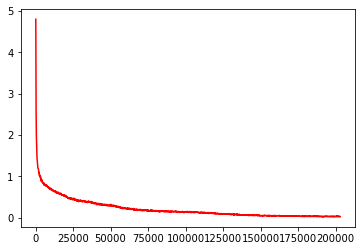

In [24]:
plt.plot(h_loss_it, h_loss, 'r')

With the data obtained during training, the first observation is that the computational cost is higher than that of a bidirectional RNN such as the model trained on the other Notewook, which was to be expected comparing the two architectures.  On the other hand, this model has a lower loss value and the acc obtained (0.986) using the Validation data is very satisfactory. 

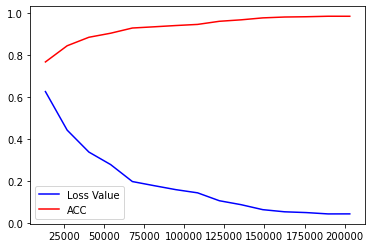

In [25]:
plt.plot(val_loss_it, val_loss, 'b', label='Loss Value')
plt.plot(val_loss_it, val_acc, 'r', label = 'ACC')
plt.legend()

In the next cell I show som expected values and predictions

In [26]:
for a, b in zip(fre, pred):
    print(a[1:])
    print(b.max(2)[1])

tensor([ 3,  4,  5,  6, 21, 15, 16, 11, 39, 13,  5, 20, 87, 89,  9, 10, 17,  2,
         0,  0,  0,  0,  0,  0], device='cuda:0')
tensor([[ 3,  4,  5,  6, 21, 15, 16, 11, 39, 13,  5, 20, 87, 89,  9, 10, 17,  2]],
       device='cuda:0')
tensor([79,  5, 52, 84, 15, 85, 11, 12, 13,  5,  6, 69, 89,  9, 10, 17,  2,  0,
         0,  0,  0,  0,  0,  0], device='cuda:0')
tensor([[79,  5, 52, 84, 15, 85, 11, 12, 13,  5,  6, 69, 89,  9, 10, 17,  2]],
       device='cuda:0')
tensor([114, 225, 132, 294,  15,  83,  15,  27,  17,   2,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0], device='cuda:0')
tensor([[114, 225, 132, 294,  15,  83,  15,  27,  17,   2]], device='cuda:0')
tensor([ 41,  92,   5,  52, 188,  15,  27,  11,  12,  13,   5,   6,  84,  15,
         32,  17,   2,   0,   0,   0,   0,   0,   0,   0], device='cuda:0')
tensor([[ 41,  92,   5,  52, 188,  15,  27,  11,  12,  13,   5,   6,  84,  15,
          32,  17,   2]], device='cuda:0')


### 3.4 Testing the model
After training the model it is necessary to test it with the test data set. With this step we can determine if our model has an over-fit, and know what the final accuracy is.

In [27]:
rnn =Encoder_Decoder(device='cpu')
path = 'models/En2Fr_tr_best_model_enc_dec1.pkl'
rnn.load_state_dict(torch.load(path))
rnn.eval()

Encoder_Decoder(
  (emb1): Embedding(232, 200)
  (emb2): Embedding(360, 250)
  (LSTM1): LSTM(200, 200, batch_first=True, bidirectional=True)
  (LSTM2): LSTM(250, 250, num_layers=2, batch_first=True)
  (Dense1): Linear(in_features=800, out_features=250, bias=True)
  (Dense2): Linear(in_features=250, out_features=1795, bias=True)
  (Dense3): Linear(in_features=1795, out_features=359, bias=True)
  (ELU1): ELU(alpha=1.0)
  (ELU2): ELU(alpha=1.0)
  (ELU3): ELU(alpha=1.0)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
)

In [28]:
loss_va = 0
acc_va = 0
count_va = 0
for eng, fre in te_ds:

    eng = eng.to('cpu')
    fre = fre.to('cpu')
    pred = rnn(eng,fre)
    
    loss = loss_function(pred, fre, criterion, len(fr_t2id)).item() 
    acc = acc_function(pred, fre)
    #count_va += pred.shape[0]
    count_va += len(pred)
    loss_va += loss * len(pred)
    acc_va += acc * len(pred)


loss_va = loss_va/count_va
acc_va = acc_va/count_va
print('The loss value with the Test Dataset is: ', loss_va)
print('The acc with the Test Dataset is: ', acc_va)

The loss value with the Test Dataset is:  0.027682218322199015
The acc with the Test Dataset is:  0.9918897263981316


## Result
The loss value and score obtained with the test data set are better than expected after the validation result. The score is 0.991, which means that our model correctly predicts 99% of the words.

After this great result it is important to remember the weaknesses of this model. To train it we have used an optimized dataset with a reduced vocabulary, which means that it is not ready for real life. Moreover, it is computationally very expensive and not optimal for situations where we need a large number of translations in a short time.

The positive reading of this test is that it shows how powerful this architecture can be.